# Effect of XGBoost on Stock Market Prediction

In this notebook we will have a look into XGBoost for stock market prediction

In [39]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

In [40]:
# Gathering data
# TODO : Create function to get data from yfinance to be used in future projects

# Testing with tomorrows data
ticker =  "AMZN"
today = date.today()
tomorrow = today + timedelta(days=1) 

amzn = yf.download(ticker, start = "2020-01-01", end = tomorrow )

[*********************100%***********************]  1 of 1 completed


In [41]:
# Verifying there are no null or na values
print(f"NA Sum: \n{amzn.isna().sum()}\n")
print(f"Null Sum: \n{amzn.isnull().sum()}")

NA Sum: 
Price   Ticker
Close   AMZN      0
High    AMZN      0
Low     AMZN      0
Open    AMZN      0
Volume  AMZN      0
dtype: int64

Null Sum: 
Price   Ticker
Close   AMZN      0
High    AMZN      0
Low     AMZN      0
Open    AMZN      0
Volume  AMZN      0
dtype: int64


In [42]:
# Adding RSI
def calculate_RSI(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower = 0)
    loss = -1 * delta.clip(upper = 0)

    avg_gain = gain.rolling(window = period, min_periods = period).mean()
    avg_loss = loss.rolling(window = period, min_periods = period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100/(1 + rs))
    return rsi
#RSI > 70 -> Overbought, chance of price going down
#RSI < 30 -> Oversold, chance of price going up

In [43]:
# Adding features that could be relevant to the model

amzn['SMA_10'] = amzn['Close'].rolling(window = 10).mean()
amzn['EMA_10'] = amzn['Close'].ewm(span = 10, adjust = False).mean()
amzn['MACD'] = amzn['Close'].rolling(window = 12).mean() - amzn['Close'].rolling(window = 26).mean()
amzn['Return'] = amzn['Close'].pct_change()
amzn['Volatility_10'] = amzn['Close'].rolling(window = 10).std()
amzn['Target'] = amzn['Close'].shift(-1)
amzn['Lag_1'] = amzn['Close'].shift(1)
amzn['Lag_2'] = amzn['Close'].shift(2)
amzn['Lag_3'] = amzn['Close'].shift(3)
amzn['Lag_4'] = amzn['Close'].shift(4)
amzn['Lag_5'] = amzn['Close'].shift(5)
amzn['Diff'] = amzn['Close'].diff()
amzn['RSI_14'] = calculate_RSI(amzn['Close'], period = 14)
amzn.tail(10)

Price,Close,High,Low,Open,Volume,SMA_10,EMA_10,MACD,Return,Volatility_10,Target,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Diff,RSI_14
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,
2025-04-25,188.990005,189.940002,185.490005,187.619995,36414300,179.014999,180.950437,-5.624167,0.013134,6.965666,187.699997,186.539993,180.600006,173.179993,167.320007,172.610001,2.450012,60.962835
2025-04-28,187.699997,190.220001,184.889999,190.110001,33224700,179.298000,182.177630,-5.628655,-0.006826,7.280352,187.389999,188.990005,186.539993,180.600006,173.179993,167.320007,-1.290009,57.865456
2025-04-29,187.389999,188.020004,183.679993,183.990005,41667300,179.825000,183.125333,-4.775257,-0.001652,7.686722,184.419998,187.699997,188.990005,186.539993,180.600006,173.179993,-0.309998,61.184649
2025-04-30,184.419998,185.050003,178.850006,182.169998,55176500,180.308000,183.360727,-4.088142,-0.015849,7.820892,190.199997,187.389999,187.699997,188.990005,186.539993,180.600006,-2.970001,44.173056
2025-05-01,190.199997,191.809998,187.500000,190.630005,74266000,181.895000,184.604230,-2.818269,0.031341,8.078962,189.979996,184.419998,187.389999,187.699997,188.990005,186.539993,5.779999,58.436676
2025-05-02,189.979996,192.880005,186.399994,191.440002,77903500,183.631999,185.581642,-1.523589,-0.001157,7.720182,186.350006,190.199997,184.419998,187.389999,187.699997,188.990005,-0.220001,55.131554
2025-05-05,186.350006,188.179993,185.529999,186.509995,35217500,185.534999,185.721345,0.055385,-0.019107,5.180126,185.009995,189.979996,190.199997,184.419998,187.389999,187.699997,-3.629990,54.174080
2025-05-06,185.009995,187.929993,183.850006,184.570007,29314100,186.717999,185.592008,1.385257,-0.007191,2.889404,188.710007,186.350006,189.979996,190.199997,184.419998,187.389999,-1.340012,55.476959


In [44]:
last_row = amzn.iloc[-1] # Saving last row for later

In [45]:
amzn.dropna(inplace = True)
amzn.tail()

Price,Close,High,Low,Open,Volume,SMA_10,EMA_10,MACD,Return,Volatility_10,Target,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Diff,RSI_14
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,
2025-05-01,190.199997,191.809998,187.500000,190.630005,74266000,181.895000,184.604230,-2.818269,0.031341,8.078962,189.979996,184.419998,187.389999,187.699997,188.990005,186.539993,5.779999,58.436676
2025-05-02,189.979996,192.880005,186.399994,191.440002,77903500,183.631999,185.581642,-1.523589,-0.001157,7.720182,186.350006,190.199997,184.419998,187.389999,187.699997,188.990005,-0.220001,55.131554
2025-05-05,186.350006,188.179993,185.529999,186.509995,35217500,185.534999,185.721345,0.055385,-0.019107,5.180126,185.009995,189.979996,190.199997,184.419998,187.389999,187.699997,-3.629990,54.174080
2025-05-06,185.009995,187.929993,183.850006,184.570007,29314100,186.717999,185.592008,1.385257,-0.007191,2.889404,188.710007,186.350006,189.979996,190.199997,184.419998,187.389999,-1.340012,55.476959
2025-05-07,188.710007,190.990005,185.009995,185.559998,44002900,187.528999,186.158917,3.227372,0.019999,1.974811,192.080002,185.009995,186.350006,189.979996,190.199997,184.419998,3.700012,65.004175


In [47]:
split_value = 0.8
split_index = int(split_value * len(amzn))
features = ['Close', 'SMA_10', 'EMA_10', 'MACD', 'Diff', 'Volatility_10', 
            'Lag_1', 'RSI_14']


X_train = amzn[features].iloc[:split_index]
y_train = amzn['Target'].iloc[:split_index]

X_test = amzn[features].iloc[split_index:]
y_test = amzn['Target'].iloc[split_index:]


In [48]:
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()

model = XGBRegressor(random_state = 1000, n_estimators = 100, max_depth = 3, eta=0.1, eval_metric = 'rmse')
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric='rmse',
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None, ...)

In [49]:
y_pred = model.predict(X_test)
train_pred = model.predict(X_train)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse)

489.7940897104563


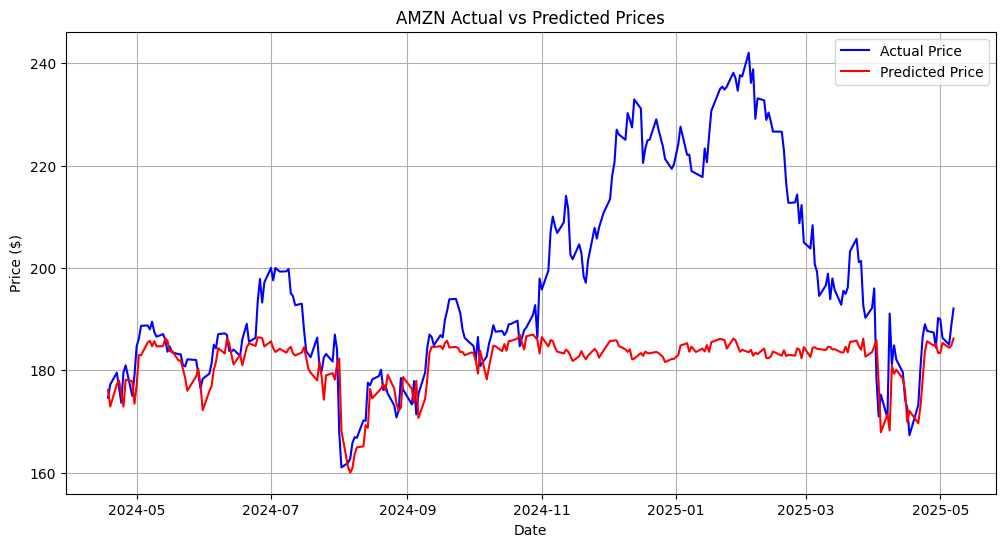

In [50]:
# Plotting the predictions

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label = "Actual Price", color = "blue")
plt.plot(y_test.index, y_pred, label = "Predicted Price", color = "red")
plt.title(f"{ticker} Actual vs Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

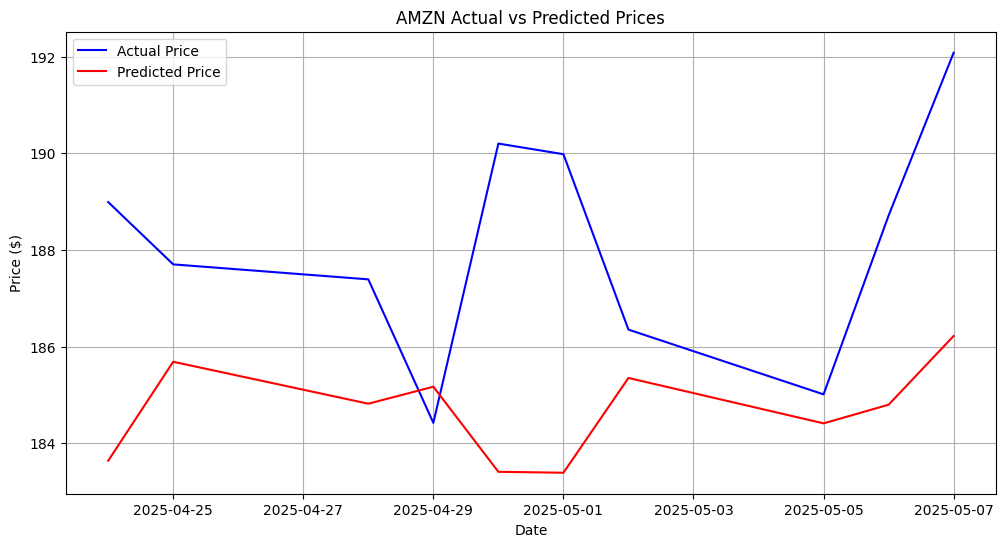

In [51]:
# Last 10 days
plt.figure(figsize=(12,6))
plt.plot(y_test.index[-10:], y_test[-10:], label = "Actual Price", color = "blue")
plt.plot(y_test.index[-10:], y_pred[-10:], label = "Predicted Price", color = "red")
plt.title(f"{ticker} Actual vs Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

The results for XGBoost are not as expected. However, parameter tuning can help us achieve a lower mse.

In [52]:
results_comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results_comparison.tail()

,Actual,Predicted
Date,,
2025-05-01,189.979996,183.388412
2025-05-02,186.350006,185.349396
2025-05-05,185.009995,184.409988
2025-05-06,188.710007,184.795425
2025-05-07,192.080002,186.217819


In [53]:
print(f"The RMSE of this model is {np.sqrt(mse):.2f}")
print(f"The R2-score of this model is {r2:.2f}")

The RMSE of this model is 22.13
The R2-score of this model is -0.36


In [54]:
def findBestNumEstimators(models, n_estimator_list, depth_list, eta_list, feature_pct_list):
    mse_list = []
    best_mse = 100000000

    for n in n_estimator_list: 
        for d in depth_list:
            for lr in eta_list:
                for f in feature_pct_list:
                    key = f"ne_{n}, depth_{d}, eta_{lr}, features_{f}"
                    models[key] = XGBRegressor(random_state = 1000, n_estimators = n, max_depth = d, eta = lr, colsample_bytree = f)
                    models[key].fit(X_train, y_train)
                    y_pred = models[key].predict(X_test)
                    mse = mean_squared_error(y_test, y_pred)
                    mse_list.append(mse)
                    if  mse < best_mse:
                        best_mse = mse
                        best_model_key = key
                        best_pred = y_pred

    return best_model_key, best_mse, mse_list, best_pred
    


In [55]:
### Commented to have a faster run time
# models = dict()
# n_estimator_list = [50, 100, 500, 1000, 2000]
# depth_list = [1,3,5,8]
# learning_rate = [ 0.1, 0.2, 0.3, 0.5]
# feature_pct = [0.5, 0.7, 1]


# best_model, best_mse, mse_list, best_pred= findBestNumEstimators(
#     models,
#     n_estimator_list, depth_list, learning_rate, feature_pct
# )
# print(f"The best model is {best_model} with an RMSE of {np.sqrt(best_mse):.2f}")

https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/

In [56]:
# # Plotting the predictions
# plt.figure(figsize=(12,6))
# plt.plot(y_test.index, y_test, label = "Actual Price", color = "blue")
# plt.plot(y_test.index, best_pred, label = "Predicted Price", color = "red")
# plt.title(f"{ticker} Actual vs Predicted Prices")
# plt.xlabel("Date")
# plt.ylabel("Price ($)")
# plt.legend()
# plt.grid(True)
# plt.show()

In [57]:
# print(f"The RMSE of the best XGBoost model is {np.sqrt(best_mse):.2f}")

# train_pred = models[best_model].predict(X_train)
# training_accuracy = mean_squared_error(y_train, train_pred)
# print(f"The RMSE of the trianing data is {np.sqrt(training_accuracy):.2f}")

I believe XGBoost is an extremely powerful tool. However, based on these results we can see that even the best values for XGBoost are overfitting the data. This is proof that there is more to be learned about XGBoost Hyperparameter tuning, and about time series in general. 

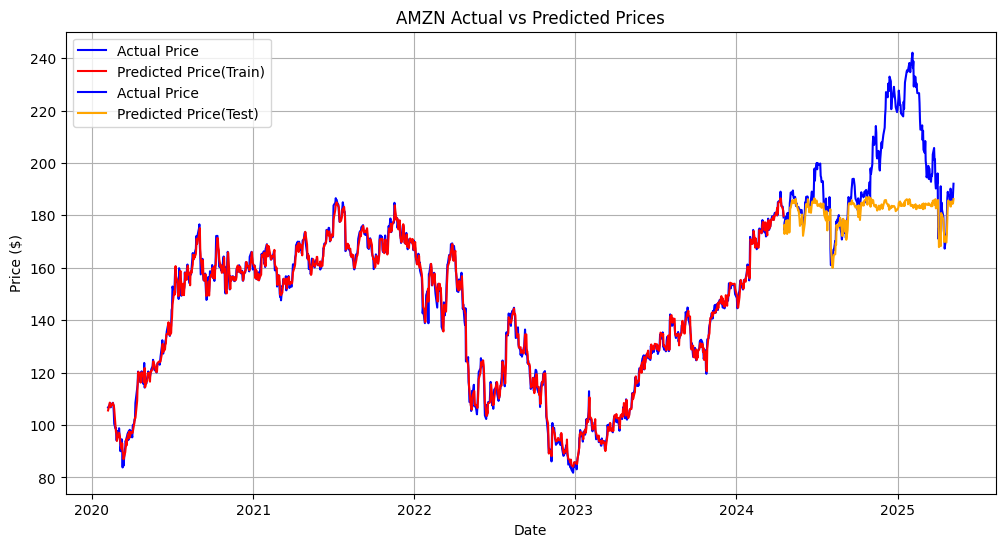

In [58]:
# Plotting the predictions(training and testing data)
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label = "Actual Price", color = "blue")
plt.plot(y_train.index, train_pred, label = "Predicted Price(Train)", color = "red")
plt.plot(y_test.index, y_test, label = "Actual Price", color = "blue")
plt.plot(y_test.index, y_pred, label = "Predicted Price(Test)", color = "orange")
plt.title(f"{ticker} Actual vs Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

### Update
In this second part we will attempt to add features to get a better MSE

In [59]:
amzn.head()

Price,Close,High,Low,Open,Volume,SMA_10,EMA_10,MACD,Return,Volatility_10,Target,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Diff,RSI_14
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,
2020-02-07,103.963997,104.926498,101.904999,102.099503,101906000,98.211198,99.626363,1.697608,0.014169,4.945534,106.695503,102.511497,101.993500,102.483498,100.209999,100.435997,1.452499,78.953916
2020-02-10,106.695503,106.779999,104.248001,104.250504,101124000,99.739049,100.911661,2.282830,0.026274,4.973304,107.540001,103.963997,102.511497,101.993500,102.483498,100.209999,2.731506,80.400655
2020-02-11,107.540001,109.297501,106.800003,107.544998,114920000,101.226799,102.116814,2.957221,0.007915,4.844781,108.000000,106.695503,103.963997,102.511497,101.993500,102.483498,0.844498,82.097420
2020-02-12,108.000000,109.012497,107.764503,108.160004,66686000,102.736799,103.186484,3.844676,0.004277,4.281573,107.493500,107.540001,106.695503,103.963997,102.511497,101.993500,0.459999,83.060478
2020-02-13,107.493500,108.514000,107.099998,107.249496,60636000,104.132749,103.969578,4.613266,-0.004690,3.044752,106.743500,108.000000,107.540001,106.695503,103.963997,102.511497,-0.506500,85.695896


Importing new libraries that will help us improve the model

In [60]:
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

We will use the Augmented Dickey-Fuller test to check for stationarity

In [61]:
adfullerResult = adfuller(amzn['Close'])
print('ADF Statistic: %f' % adfullerResult[0])
print('p-value: %f' % adfullerResult[1])
print('Critical Values:')
for key, value in adfullerResult[4].items():
	print('\t%s: %.3f' % (key, value))
if (adfullerResult[1] <= 0.05) & (adfullerResult[4]['5%'] > adfullerResult[0]):
    print("\u001b[32mStationary\u001b[0m")
else:
    print("\x1b[31mNon-stationary\x1b[0m")

adfullerResult = adfuller(amzn['Return'])
print('ADF Statistic: %f' % adfullerResult[0])
print('p-value: %f' % adfullerResult[1])
print('Critical Values:')
for key, value in adfullerResult[4].items():
	print('\t%s: %.3f' % (key, value))
if (adfullerResult[1] <= 0.05) & (adfullerResult[4]['5%'] > adfullerResult[0]):
    print("\u001b[32mStationary\u001b[0m")
else:
    print("\x1b[31mNon-stationary\x1b[0m")

ADF Statistic: -1.868169
p-value: 0.347180
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Non-stationary
ADF Statistic: -37.804710
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Stationary


We can see with the ADF test that the values are Closing value is not stationary but the returns (technically the first derivative) is stationary, which suggests that we should add variables related to stationarity.

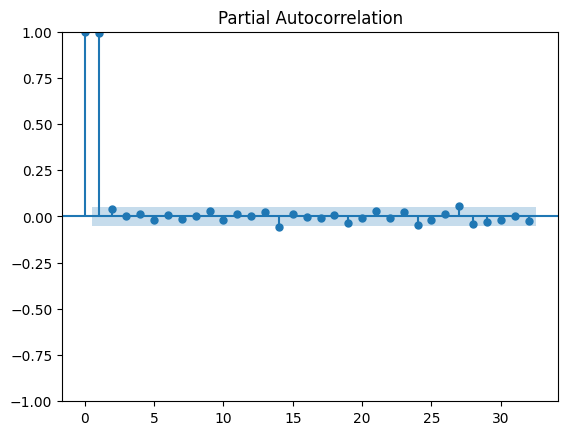

In [62]:
plot_pacf(amzn['Close'], method='ywm')
plt.show()

The PACF Plot shows there is strong autocorrelation only with the previous day.

With this info in mind, we can attempt a different stock price prediction, predicting the returns instead of the actual value.

We will focus on the closing price, thus we will open, high and low.

In [63]:
print(features)

['Close', 'SMA_10', 'EMA_10', 'MACD', 'Diff', 'Volatility_10', 'Lag_1', 'RSI_14']


In [64]:
featureScaler = MinMaxScaler()
targetScaler = MinMaxScaler()


In [65]:
# Define the number of lags and the test size for each iteration
n_lags = 10
n_test = 1

# Initialize lists to store predictions and actual values
predictions = []
actual = []

X = amzn[features].values
y = amzn['Close'].values

model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Perform walk-forward validation
for i in tqdm(range(len(X) - n_lags - n_test + 1)):
    X_train, X_test = X[i:i+n_lags], X[i+n_lags:i+n_lags+n_test]
    y_train, y_test = y[i:i+n_lags], y[i+n_lags:i+n_lags+n_test]

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    predictions.extend(y_pred)
    actual.extend(y_test)

# Calculate the Mean Squared Error
actual = [val[0] for val in actual] # if n_test >1, then it would contain a list of predictions for n_test days
mse = mean_squared_error(actual, predictions)
print(f"Mean Squared Error: {mse:.4f}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.4f}")
    

100%|██████████| 1309/1309 [01:02<00:00, 20.82it/s]

Mean Squared Error: 5.1362
Root Mean Squared Error: 2.2663


After using look_forward validation, the performance of the model imporves significantly.

In [66]:
# Training for an unknown day 
X_train = amzn[-10:][features].values
X_test = last_row[features].values.reshape(1, -1)
y_train = amzn[-10:]['Close'].values
model.fit(X_train, y_train)
last_prediction = model.predict(X_test)

print(X_train.shape)
print(X_test.shape)

(10, 8)
(1, 8)


In [67]:
result_dates = amzn.reset_index()['Date'][10:]
data = {
'Values': actual,
'Predictions': predictions}
result_df = pd.DataFrame(
data = data, index = result_dates
)
result_df

,Values,Predictions
Date,,
2020-02-24,100.464500,103.981277
2020-02-25,98.637001,100.500900
2020-02-26,98.979500,98.677910
2020-02-27,94.214996,98.664330
2020-02-28,94.187500,94.273232
...,...,...
2025-05-01,190.199997,188.943649
2025-05-02,189.979996,188.978363
2025-05-05,186.350006,184.420197


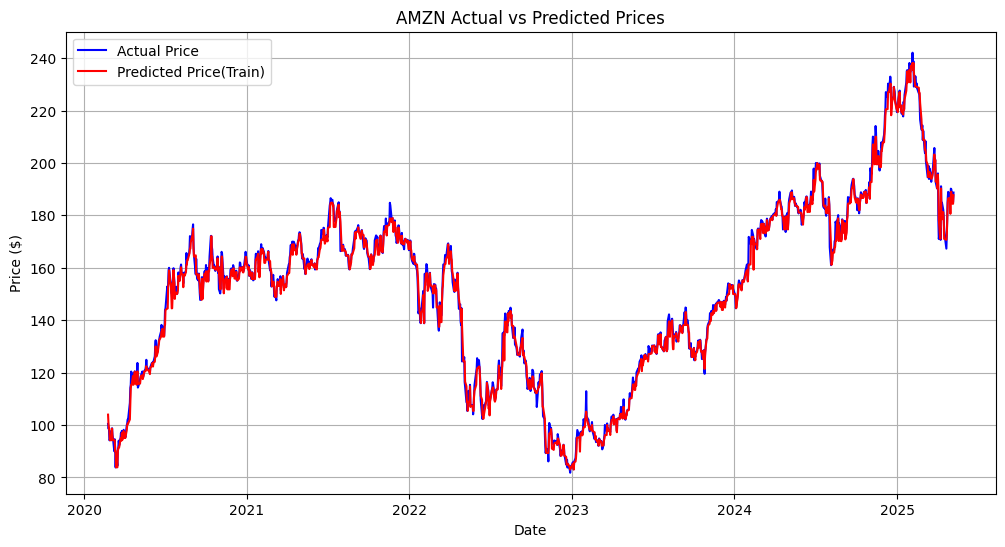

In [68]:
# Plotting the predictions(training and testing data)
plt.figure(figsize=(12,6))
plt.plot(result_df.index, actual, label = "Actual Price", color = "blue")
plt.plot(result_df.index, predictions, label = "Predicted Price(Train)", color = "red")
plt.title(f"{ticker} Actual vs Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

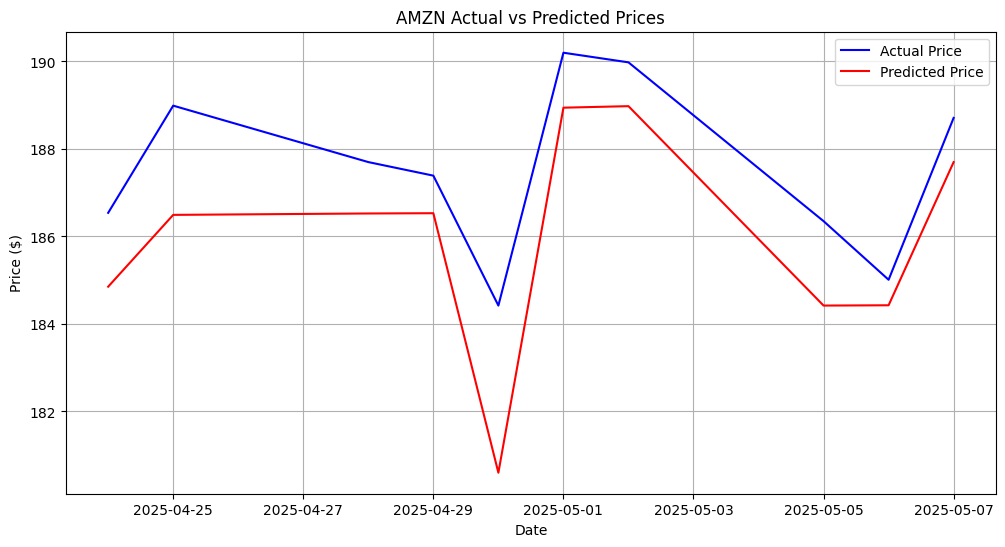

In [69]:
# Last 10 days
plt.figure(figsize=(12,6))
plt.plot(result_df.index[-10:], actual[-10:], label = "Actual Price", color = "blue")
plt.plot(result_df.index[-10:], predictions[-10:], label = "Predicted Price", color = "red")
plt.title(f"{ticker} Actual vs Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

In [84]:
print(last_prediction)
last_row.head()

[190.18706]


Price   Ticker
Close   AMZN      1.920800e+02
High    AMZN      1.943300e+02
Low     AMZN      1.888200e+02
Open    AMZN      1.914750e+02
Volume  AMZN      4.065113e+07
Name: 2025-05-08 00:00:00, dtype: float64